# Car Price Prediction

## Machine Learning Regression Algorithm Selection

*Eduardo Solano Jaime*

*0213663*

*ECID*

*Universidad Panamericana campus Guadalajara*

---

### Objective

The following Notebookaims to build a machine learning regression algorithm in order to predict the price of cars based on a the data set [Car Price Prediction(used cars)](https://www.kaggle.com/datasets/vijayaadithyanvg/car-price-predictionused-cars/). Following the checklist provided during class, the proyect will tackle the problem from the begining: including setting the goal of the code, prepare and process the data, feature engineering, odel  building and testing, and final cross validation to determine the optimal method to predict prices.

### Obtain and sample the data

In [910]:
import pandas as pd

dataset = 'car data.csv'
df= pd.read_csv(dataset, sep=',')
names = df.columns
df.sample(3)

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
7,s cross,2015,6.50,8.610,33429,Diesel,Dealer,Manual,0
146,Hero Extreme,2014,0.55,0.787,15000,Petrol,Individual,Manual,0
265,jazz,2017,6.50,8.700,21200,Petrol,Dealer,Manual,0


### Analysis each feature and its characteristics

In [911]:
print(f'The dataset has a size of {df.shape}')
df.info()

The dataset has a size of (301, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [912]:
for name in names:
    print(name, df.loc[:, name].unique()[:min(5, len(df.loc[:, name].unique()))], len(df.loc[:, name].unique()))

Car_Name ['ritz' 'sx4' 'ciaz' 'wagon r' 'swift'] 98
Year [2014 2013 2017 2011 2018] 16
Selling_Price [3.35 4.75 7.25 2.85 4.6 ] 156
Present_Price [5.59 9.54 9.85 4.15 6.87] 148
Driven_kms [27000 43000  6900  5200 42450] 206
Fuel_Type ['Petrol' 'Diesel' 'CNG'] 3
Selling_type ['Dealer' 'Individual'] 2
Transmission ['Manual' 'Automatic'] 2
Owner [0 1 3] 3


We have a total of 8 features + target feature before feature engineering. We can clearly see that some of the columns contain categorical and other numerical data, therefore a preprocessing must be made in order to analyze in depths the dataset to determine wether noise is present and extrat statistical information.

In [913]:
names = df.columns
names.values

array(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms',
       'Fuel_Type', 'Selling_type', 'Transmission', 'Owner'], dtype=object)

Now, before using Pipelines to transform further the date we split it in a 80-20 ratio between test and train. We wont see the test set until the end of the analysis

In [914]:
from sklearn.model_selection import train_test_split

df.columns = [x.replace('_', '') for x in df.columns]
names = df.columns
target = 'PresentPrice'
y = df.loc[:, target]
X = df.loc[:, [x for x in df.columns.values if x!=target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train.sample(5)

,CarName,Year,SellingPrice,Drivenkms,FuelType,Sellingtype,Transmission,Owner
262,amaze,2015,4.00,40023,Petrol,Dealer,Manual,0
196,Activa 3g,2008,0.17,500000,Petrol,Individual,Automatic,0
150,TVS Apache RTR 180,2011,0.50,6000,Petrol,Individual,Manual,0
219,verna,2012,4.50,36000,Petrol,Dealer,Manual,0
128,Honda CB Hornet 160R,2017,0.80,3000,Petrol,Individual,Manual,0


### Transform data

Check normality of the target

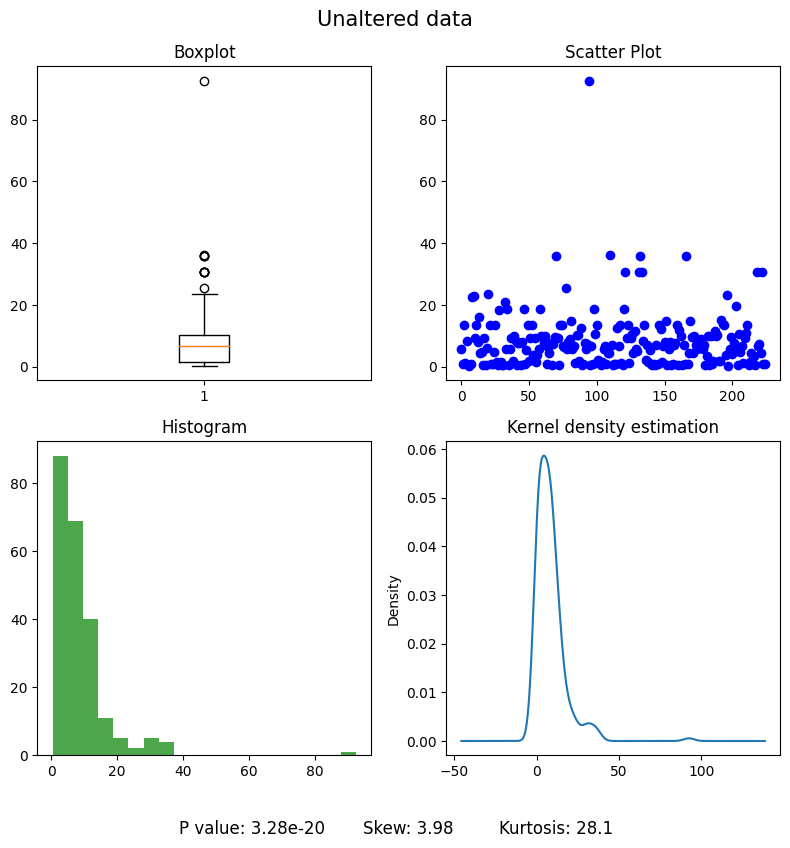

In [915]:
import matplotlib.pyplot as plt
import seaborn as sea
from scipy.stats import shapiro, skew, kurtosis

def Visualize(data, title):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(title, size=15)
    
    axs[0, 0].boxplot(data)
    axs[0, 0].set_title('Boxplot')

    axs[0, 1].scatter(range(len(data)), data, c='b', marker='o')
    axs[0, 1].set_title('Scatter Plot')

    axs[1, 0].hist(data, bins=20, color='g', alpha=0.7)
    axs[1, 0].set_title('Histogram')
    
    axs[1, 1] = data.plot.kde()
    axs[1, 1].set_title('Kernel density estimation')

    _, p = shapiro(data)
    fig.text(.23, -.05, f"P value: {p:,.3}", size=12)
    fig.text(.46, -.05, f"Skew: {skew(data):,.3}", size=12)
    fig.text(.63, -.05, f"Kurtosis: {kurtosis(data):,.3}", size=12)
    plt.tight_layout()
    plt.show()

Visualize(y_train, 'Unaltered data')

Seeing the data plots and since the value of p is less than 0.05 the data is not normal. We can try diferent method to make the data more normally distributed.

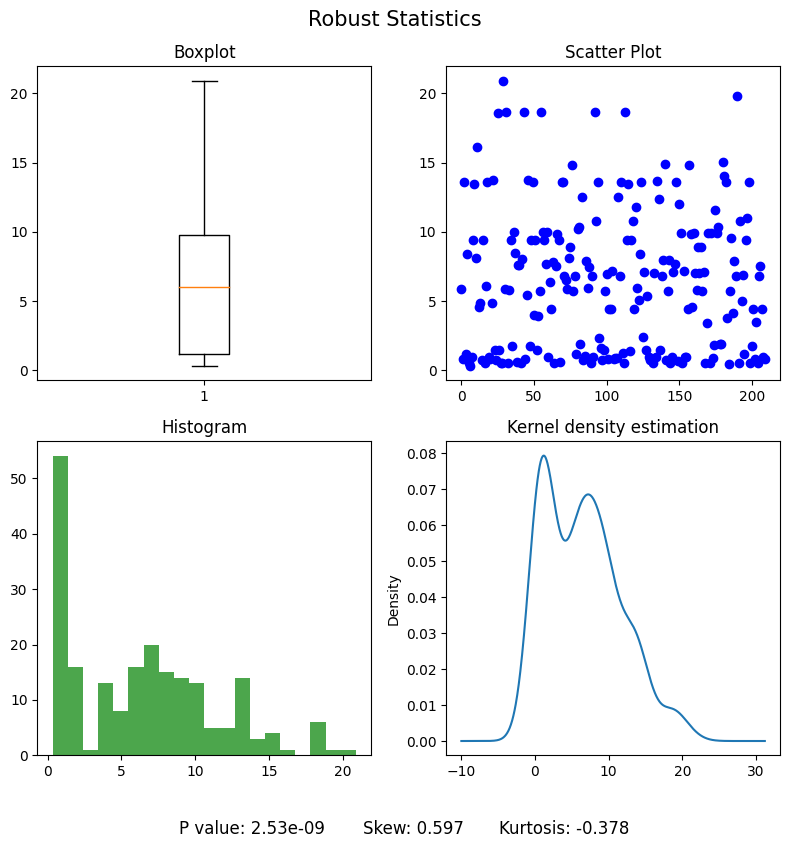

In [916]:
import numpy as np

X_train[target] = y_train

while True:
    q1 = np.percentile(X_train[target] , 25)
    q3 = np.percentile(X_train[target] , 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    if(X_train[(X_train[target]  < lower_bound) | (X_train[target] > upper_bound)].empty):
        break
    X_train = X_train[(X_train[target]  >= lower_bound) & (X_train[target] <= upper_bound)]

Visualize(X_train[target] , 'Robust Statistics')

y_train = X_train[target] 
X_train.drop(target, axis=1, inplace=True)

For **Categorical data** specific transformations are to be made:
 - Nominal variables
   - *CarName* - LabelEncoder (although I suspect the car name is going to have no correlation with the price)
   - *FuelType* LabelEncoder or OneHotEncoder
   - *Sellingtype* and *Transmission* simple replacement

For **Numerical data** a simple StandardScaler is going to be used since there are no missing values

In [917]:
# Numerical data
numeric = ['Year', 'SellingPrice', 'Drivenkms', 'Owner']

# Binary cata
binary = ['Sellingtype', 'Transmission']

# Easy binary replacements for binary columns
X_train[binary] = X_train.loc[:, binary].replace({'Dealer':0,  'Individual':1, 'Manual':0, 'Automatic':1})
X_test[binary] = X_test.loc[:, binary].replace({'Dealer':0,  'Individual':1, 'Manual':0, 'Automatic':1})

X_train.sample(3)

,CarName,Year,SellingPrice,Drivenkms,FuelType,Sellingtype,Transmission,Owner
273,jazz,2010,2.25,61203,Petrol,0,0,0
226,grand i10,2015,5.25,24678,Petrol,0,0,0
23,alto k10,2014,2.50,45280,Petrol,0,0,0


### Extra features

I theorize that the relationship between the year the car was sold and how many kilometers weights heavily. I am adding an extra feature to relate them

In [918]:
X_train['WellKept'] = X_train.loc[:, 'Drivenkms'] * X_train.loc[:, 'Year'] # type: ignore
X_test['WellKept'] = X_test.loc[:, 'Drivenkms'] * X_test.loc[:, 'Year'] # type: ignore
numeric = ['Year', 'SellingPrice', 'Drivenkms', 'WellKept']
names = X_train.columns

In [919]:
# pip install category-encoders

In [973]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from category_encoders import BinaryEncoder, OneHotEncoder

ct = ColumnTransformer(transformers=
                       [('imputer', SimpleImputer(), numeric),
                        ('numeric', StandardScaler(), numeric),
                        ('cars', BinaryEncoder(), ['CarName']),
                        ('fuel', OrdinalEncoder(), ['FuelType'])],
                       remainder='passthrough')

X_train_fit = ct.fit_transform(X_train)
columns = numeric + [x for x in list(ct.get_feature_names_out()[4:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_train_fit = pd.DataFrame(X_train_fit, columns=columns)
X_train_fit.drop(numeric, axis=1, inplace=True)

X_test_fit = ct.fit_transform(X_test)
columns = numeric + [x for x in list(ct.get_feature_names_out()[4:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_test_fit = pd.DataFrame(X_test_fit, columns=columns)
X_test_fit.drop(numeric, axis=1, inplace=True)

X_train_fit.sample(5)

,numeric__Year,numeric__SellingPrice,numeric__Drivenkms,numeric__WellKept,cars__CarName_0,cars__CarName_1,cars__CarName_2,cars__CarName_3,cars__CarName_4,cars__CarName_5,cars__CarName_6,FuelType,Sellingtype,Transmission,Owner
79,0.772051,-0.866611,-0.700499,-0.701639,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0
138,0.417279,0.401204,-0.103112,-0.102229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0
167,0.417279,0.211761,0.001179,0.002427,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0
62,-0.292264,-0.327425,0.494863,0.496509,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
14,-0.292264,-0.983192,-0.465557,-0.466319,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0


### Correlation Matrix

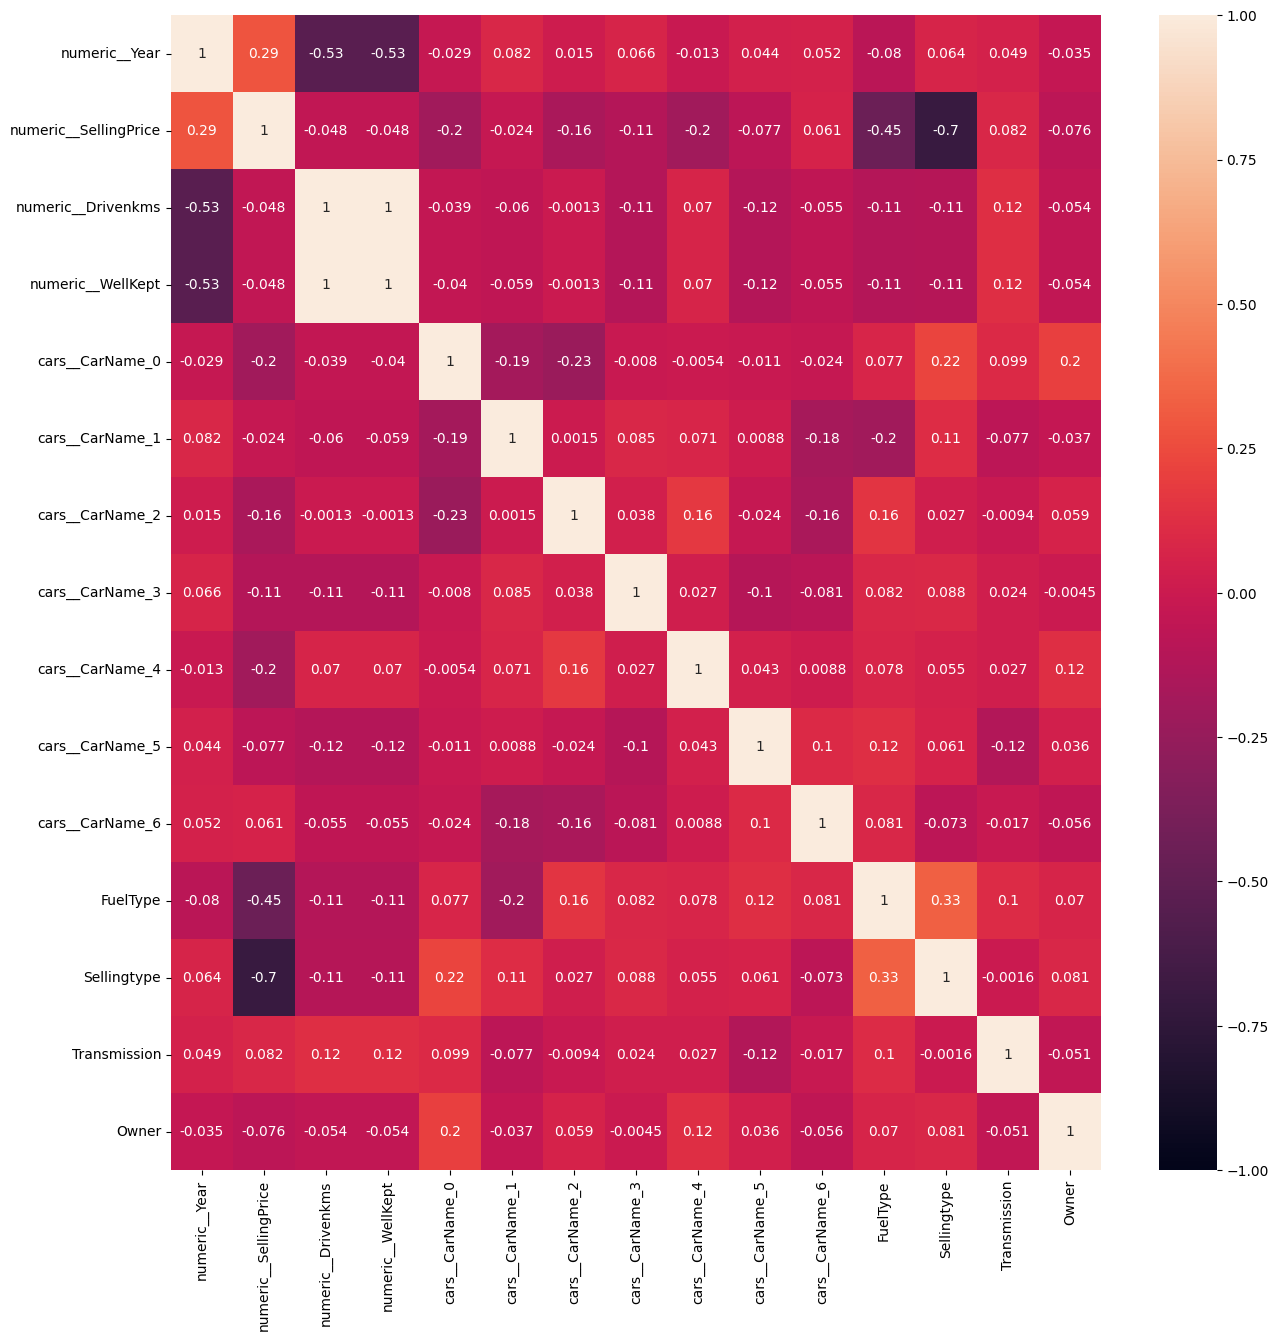

In [921]:
correlation = X_train_fit.corr()
fig1 = plt.figure(figsize=(15,15))
ax = sea.heatmap(correlation, annot=True, vmin=-1, vmax=1)
plt.show()

There are some positively correlated features

Now, feature engineering is needed to remove those higly correlated features

In [991]:
import numpy as np

corr = X_train_fit.corr().abs() # type: ignore
up = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in up.columns if any(up[column] > 0.7)]
X_train_fit.drop(to_drop, axis=1, inplace=True)
X_test_fit.drop(to_drop, axis=1, inplace=True)
X_train_fit.sample(3)

,numeric__Year,numeric__SellingPrice,numeric__Drivenkms,cars__CarName_0,cars__CarName_1,cars__CarName_2,cars__CarName_3,cars__CarName_4,cars__CarName_5,cars__CarName_6,FuelType,Sellingtype,Transmission,Owner
29,0.772051,2.980553,-0.559534,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
159,-1.001808,-0.385716,-0.312445,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0
19,0.417279,-0.997765,-0.451461,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0


### Shortlist Promising Models

In [923]:
# Get the models

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
import xgboost as xgb

models = [LinearRegression(), PolynomialFeatures(include_bias=False), Ridge(), Lasso(), DecisionTreeRegressor(),
          RandomForestRegressor(), SGDRegressor(), KNeighborsRegressor(), BayesianRidge(), xgb.XGBRegressor()]

xgb.set_config(verbosity=0)

In [924]:
first_scores = []
for model in models:
    score = 0
    if str(model)=='PolynomialFeatures(include_bias=False)':
        model = LinearRegression()
        poly_features = PolynomialFeatures()
        X_poly = poly_features.fit_transform(X_train_fit)
        model.fit(X_poly, y_train)
        score = model.score(X_poly, y_train)
        model = PolynomialFeatures()
        first_scores.append(score)
    else:
        model.fit(X_train_fit, y_train)
        score = model.score(X_train_fit, y_train)
        first_scores.append(score)
    print(f"Score of {score:.5f} was achieved with {model}")

Score of 0.87527 was achieved with LinearRegression()
Score of 0.97252 was achieved with PolynomialFeatures()
Score of 0.87518 was achieved with Ridge()
Score of 0.71463 was achieved with Lasso()
Score of 1.00000 was achieved with DecisionTreeRegressor()
Score of 0.98492 was achieved with RandomForestRegressor()
Score of 0.86480 was achieved with SGDRegressor()
Score of 0.91839 was achieved with KNeighborsRegressor()
Score of 0.87504 was achieved with BayesianRidge()
Score of 1.00000 was achieved with XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max

Before jumping to any conclusions about the performance of the models, I want to try a different feature engineering in which the *CarName* and *FuelType* columns go through a OneHotEncoder
So we change the Transformers and perform everything again

In [925]:
ct2 = ColumnTransformer(transformers=
                       [('imputer', SimpleImputer(), numeric),
                        ('numeric', StandardScaler(), numeric),
                        ('category', OneHotEncoder(), ['CarName', 'FuelType'])],
                       remainder='passthrough')

X_train_fit2 = ct2.fit_transform(X_train)
columns2 = numeric + [x for x in list(ct2.get_feature_names_out()[4:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_train_fit2 = pd.DataFrame(X_train_fit2, columns=columns2)
X_train_fit2.drop(numeric, axis=1, inplace=True)

corr = X_train_fit2.corr().abs()
up = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop2 = [column for column in up.columns if any(up[column] > 0.7)]
X_train_fit2.drop(to_drop2, axis=1, inplace=True)

for model, old_score in zip(models, first_scores):
    if str(model)=='PolynomialFeatures(include_bias=False)':
        model = LinearRegression()
        poly_features = PolynomialFeatures(degree=2)
        X_poly = poly_features.fit_transform(X_train_fit2)
        model.fit(X_poly, y_train)
        score = model.score(X_poly, y_train)
        model = PolynomialFeatures()
    else:
        model.fit(X_train_fit2, y_train)
        score = model.score(X_train_fit2, y_train)
    print(f"Score of {score:.5f} was achieved with {model}, ", end='')
    if old_score<score:
        print(f"improvement of {abs(old_score-score):.5f}")
    elif old_score==score:
        print('same score')
    else:
        print(f"setback of {(old_score-score):.5f}")

Score of 0.97331 was achieved with LinearRegression(), improvement of 0.09804
Score of 0.99460 was achieved with PolynomialFeatures(), improvement of 0.02208
Score of 0.96162 was achieved with Ridge(), improvement of 0.08644
Score of 0.71463 was achieved with Lasso(), same score
Score of 1.00000 was achieved with DecisionTreeRegressor(), same score
Score of 0.98888 was achieved with RandomForestRegressor(), improvement of 0.00396
Score of 0.94609 was achieved with SGDRegressor(), improvement of 0.08129
Score of 0.93352 was achieved with KNeighborsRegressor(), improvement of 0.01512
Score of 0.96622 was achieved with BayesianRidge(), improvement of 0.09118
Score of 0.99995 was achieved with XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gr

Although a general improvement is seen in the different models, we are only increasing the overfitting. Therefore we keep the original column transformer

Now we can pick our top 3 candidate, and according to their scores:
1. **DecisionTreeRegressor()**
2. **RandomForest()**
3. **XGBRegressor()**

Identify the most and least important features of each model.

In [926]:
tree = DecisionTreeRegressor()
tree_m = tree.fit(X_train_fit, y_train)

forest = RandomForestRegressor()
forest_m = forest.fit(X_train_fit, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, warm_start=True)
xgbr_m = xgbr.fit(X_train_fit, y_train)

print('Most important:')
print(f"Tree: {[list(X_train_fit.columns)[i] for i in np.argsort(tree_m.feature_importances_)[::-1][:5]]}")
print(f"Forest: {[list(X_train_fit.columns)[i] for i in np.argsort(forest_m.feature_names_in_)[::-1][:5]]}") 
print(f"XGB: {[list(X_train_fit.columns)[i] for i in np.argsort(xgbr.feature_names_in_)[::-1][:5]]}")
print()
print('Least important')
print(f"Tree: {[list(X_train_fit.columns)[i] for i in np.argsort(tree_m.feature_importances_)[:5]]}")
print(f"Forest: {[list(X_train_fit.columns)[i] for i in np.argsort(forest_m.feature_names_in_)[:5]]}") 
print(f"XGB: {[list(X_train_fit.columns)[i] for i in np.argsort(xgbr.feature_names_in_)[:5]]}")

Most important:
Tree: ['numeric__SellingPrice', 'numeric__Year', 'numeric__Drivenkms', 'cars__CarName_2', 'cars__CarName_3']
Forest: ['numeric__Year', 'numeric__SellingPrice', 'numeric__Drivenkms', 'cars__CarName_6', 'cars__CarName_5']
XGB: ['numeric__Year', 'numeric__SellingPrice', 'numeric__Drivenkms', 'cars__CarName_6', 'cars__CarName_5']

Least important
Tree: ['FuelType', 'Sellingtype', 'cars__CarName_1', 'Owner', 'cars__CarName_5']
Forest: ['FuelType', 'Owner', 'Sellingtype', 'Transmission', 'cars__CarName_0']
XGB: ['FuelType', 'Owner', 'Sellingtype', 'Transmission', 'cars__CarName_0']


### Fine-Tune the models

In [927]:
from sklearn.model_selection import GridSearchCV

param_grids = [
    {'max_depth': [None, 10, 20, 30],               # DecisionTree
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],},
    {'n_estimators': [100, 150, 200],                   # RandomForest
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]},
    {'n_estimators': [100, 150, 200, 300],                   # XGBoost
    'eta': [0.01, 0.05, 0.1, 0.5],
    'subsample': [0.5, 1]}
    ]

regressors = [tree, forest, xgbr]
best_estimator = []
for regressor, param_grid in zip(regressors, param_grids):
    grid_search = GridSearchCV(regressor, param_grid, cv=5)
    grid_search.fit(X_train_fit, y_train)
    print(f"{regressor}: {grid_search.best_estimator_}")
    print(f"Best params: {grid_search.best_params_}")
    print(f"Accuracy: {grid_search.score(X_train_fit, y_train):,.3f}", '\n')
    best_estimator.append(grid_search.best_estimator_)


DecisionTreeRegressor(): DecisionTreeRegressor(max_depth=30)
Best params: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 1.000 

RandomForestRegressor(): RandomForestRegressor(max_depth=10, n_estimators=150)
Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.986 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy

Now that we have determined the best model is **XGBRegressor**

In [928]:
model = best_estimator[2]
model_m = model.fit(X_train_fit, y_train)

## Cross Validation

In [929]:
X = pd.concat([X_train_fit, X_test_fit])
y = pd.concat([y_train, y_test])

### KFolding

In [930]:
from sklearn.model_selection import KFold, cross_val_score

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, )
result = cross_val_score(model, X, y, cv=kfold)
print(f"La media de los {len(result)} folds es {result.mean()*100:,.3f}% con std de {result.std():,.3f}")

La media de los 10 folds es 90.169% con std de 0.028


### Repeated KFolding

In [931]:
from sklearn.model_selection import RepeatedKFold

num_folds = 10
num_repeated = 20
repeatedkfold = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeated)
result = cross_val_score(model, X, y, cv=repeatedkfold)
print(f"Accuracy: {result.mean()*100:,.3f}%, std {result.std():,.3f}")

Accuracy: 91.249%, std 0.043


In [1009]:
def DataTransform(data: list) -> pd.DataFrame:
  data = [{name:x for name, x in zip([i for i in names if i!=target and i!='WellKept'], data)}]
  X = pd.DataFrame(data)
  X[binary] = X.loc[:, binary].replace({'Dealer':0,  'Individual':1, 'Manual':0, 'Automatic':1})
  X['WellKept'] = X.loc[:, 'Drivenkms'] * X.loc[:, 'Year']
  X_fit = ct.transform(X)
  columns = numeric + [x for x in list(ct.get_feature_names_out()[4:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
  X_fit = pd.DataFrame(X_fit, columns=columns) 
  X_fit.drop(numeric, axis=1, inplace=True)
  X_fit.drop(to_drop, axis=1, inplace=True)
  X_fit = pd.concat([pd.DataFrame(columns=X_train_fit.columns.values), X_fit])
  X_fit.fillna(0, inplace=True)
  return X_fit

In [1012]:
example = ['gol', 2018, 10.5, 700000, 'Petrol', 'Individual', 'Manual', 0]
example = DataTransform(example)

print(f"Estimated price of {list(model_m.predict(example))[0]:,.4} k dollars")

Estimated price of 11.71 k dollars
